In [1]:
#!/usr/bin/env python
import numpy as np
#import matplotlib.pyplot as plt
import os
import sys
import glob
from sys import getsizeof
import uproot

import warnings
warnings.filterwarnings('ignore')

In [2]:
files = sorted(glob.glob('/media/monongyu/L2V14/L2V14_MC/*flat*.root'))

In [29]:
elements = ['C', 'Fe', 'He', 'N', 'O', 'p']
sparsi_level = [1, 1.5, 2, 3, 4, 5, 6]
#read MC and save
for factor in sparsi_level:
    for e in range(len(files)):
        f = uproot.open(files[e])

        X = f['L2']['fCal/DetBranch/fX'].array()
        Y = f['L2']['fCal/DetBranch/fY'].array()
        Z = f['L2']['fCal/DetBranch/fZ'].array()
        Adc = f['L2']['fCal/DetBranch/fAdc'].array()

        TrueE = f['L2']['fTrue/fEnergy'].array()
        Charge = f['L2']['fTrue/fCharge'].array()
        
        TotalEdep_dummy = f['L2']['fEvent/fEvent.CALTotalEdep'].array()
        TotalEdep = []
        for i in range(len(TotalEdep_dummy)):
            TotalEdep.append(TotalEdep_dummy[i][0])
        TotalEdep = np.array(TotalEdep)

        Tracking_angle_dummy = f['L2']['fEvent/fEvent.PDIRCOS[3]'].array()
        Tracking_angle = []
        for i in range(len(Tracking_angle_dummy)):
            Tracking_angle.append(Tracking_angle_dummy[i][3][2])
        Tracking_angle = np.array(Tracking_angle)

        #prepare for imgs
        x_all, y_all, xz_all, yz_all = [], [], [], []
        ADC_xz_all, ADC_yz_all = [],[]
        evtnum = len(TrueE)
        for i in range(evtnum):
            x_idx = np.where(abs(X[i])>0.001)[0]
            y_idx = np.where(abs(Y[i])>0.001)[0]
            x_pos = X[i][x_idx]
            y_pos = Y[i][y_idx]
            xz_pos = Z[i][x_idx]
            yz_pos = Z[i][y_idx]

            ADC_xz = Adc[i][x_idx]
            invalid_x_idx = np.where(ADC_xz<20*factor)[0] #set -9999 Adc to 0 and set sparsi level
            ADC_xz[invalid_x_idx] = 0

            ADC_yz = Adc[i][y_idx]
            invalid_y_idx = np.where(ADC_yz<20*factor)[0] #set -9999 Adc to 0
            ADC_yz[invalid_y_idx] = 0

            x_all.append(x_pos)
            y_all.append(y_pos)
            xz_all.append(xz_pos)
            ADC_xz_all.append(ADC_xz)
            yz_all.append(yz_pos)
            ADC_yz_all.append(ADC_yz)

        x_all = np.array(x_all)
        y_all = np.array(y_all)
        xz_all = np.array(xz_all)
        yz_all = np.array(yz_all)
        ADC_xz_all = np.array(ADC_xz_all)
        ADC_yz_all = np.array(ADC_yz_all) 

        #save images
        xz_imgs, yz_imgs = [],[]
        valid_idx = np.where(TotalEdep > 300*6)[0] #valid_idx based on TotalEdep (MeV)
        
        for idx in valid_idx:
            x_pix, y_pix = np.round(x_all[idx]/10-0.5)+25.5, np.round(y_all[idx]/10-0.5)+25.5
            xz_pix = np.round(xz_all[idx]/4.55)-0.5
            yz_pix = np.round(yz_all[idx]/4.55)-0.5

            xz_img, buf, buf = np.histogram2d(x_pix, xz_pix, weights=ADC_xz_all[idx], bins=(range(51), range(21)) )   
            yz_img, buf, buf = np.histogram2d(y_pix, yz_pix, weights=ADC_yz_all[idx], bins=(range(51), range(21)) ) 

            xz_imgs.append(xz_img)
            yz_imgs.append(yz_img)
        xz_imgs = np.array(xz_imgs)
        yz_imgs = np.array(yz_imgs)

        #merge xz and yz imgs
        xzyz_imgs_vertical_dummy = []
        xzyz_imgs_vertical = []

        for i in range(len(xz_imgs)):
            xzyz_imgs_vertical_dummy.append(np.rot90(np.append(yz_imgs[i], xz_imgs[i], axis=1),1))
        xzyz_imgs_vertical_dummy = np.array(xzyz_imgs_vertical_dummy)

        valid_idx2 = []  #valid_idx2 based on ADC value 
        for idx2 in range(len(valid_idx)):
            if xzyz_imgs_vertical_dummy[idx2].sum() > 600: 
                valid_idx2.append(idx2)
                xzyz_imgs_vertical.append(xzyz_imgs_vertical_dummy[idx2]/xzyz_imgs_vertical_dummy[idx2].sum()) #sum norm
        xzyz_imgs_vertical = np.array(xzyz_imgs_vertical)
        
        #Save to numpy file
        np.save('./data/%s_flat_imgsX%s.npy'%(elements[e],str(factor)), xzyz_imgs_vertical)
        np.save('./data/%s_flat_true_energyX%s.npy'%(elements[e],str(factor)), TrueE[valid_idx[valid_idx2]])
        np.save('./data/%s_flat_chargeX%s.npy'%(elements[e],str(factor)), Charge[valid_idx[valid_idx2]])
        np.save('./data/%s_flat_angleX%s.npy'%(elements[e],str(factor)), Tracking_angle[valid_idx[valid_idx2]])
        print('%s: '%elements[e]+str(len(xzyz_imgs_vertical)) + ' events, sparsi = X'+str(factor) \
             + 'len(TrueE): %s'%str(len(TrueE[valid_idx[valid_idx2]])))

C: 15423 events, sparsi = X1len(TrueE): 15423
Fe: 9357 events, sparsi = X1len(TrueE): 9357
He: 5207 events, sparsi = X1len(TrueE): 5207
N: 5926 events, sparsi = X1len(TrueE): 5926
O: 8961 events, sparsi = X1len(TrueE): 8961
p: 33165 events, sparsi = X1len(TrueE): 33165
C: 14368 events, sparsi = X1.5len(TrueE): 14368
Fe: 8391 events, sparsi = X1.5len(TrueE): 8391
He: 4950 events, sparsi = X1.5len(TrueE): 4950
N: 5566 events, sparsi = X1.5len(TrueE): 5566
O: 8257 events, sparsi = X1.5len(TrueE): 8257
p: 32135 events, sparsi = X1.5len(TrueE): 32135
C: 13638 events, sparsi = X2len(TrueE): 13638
Fe: 7858 events, sparsi = X2len(TrueE): 7858
He: 4741 events, sparsi = X2len(TrueE): 4741
N: 5285 events, sparsi = X2len(TrueE): 5285
O: 7834 events, sparsi = X2len(TrueE): 7834
p: 31070 events, sparsi = X2len(TrueE): 31070
C: 12732 events, sparsi = X3len(TrueE): 12732
Fe: 7221 events, sparsi = X3len(TrueE): 7221
He: 4499 events, sparsi = X3len(TrueE): 4499
N: 4944 events, sparsi = X3len(TrueE): 494

/home/monongyu/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("rainbow"))
  


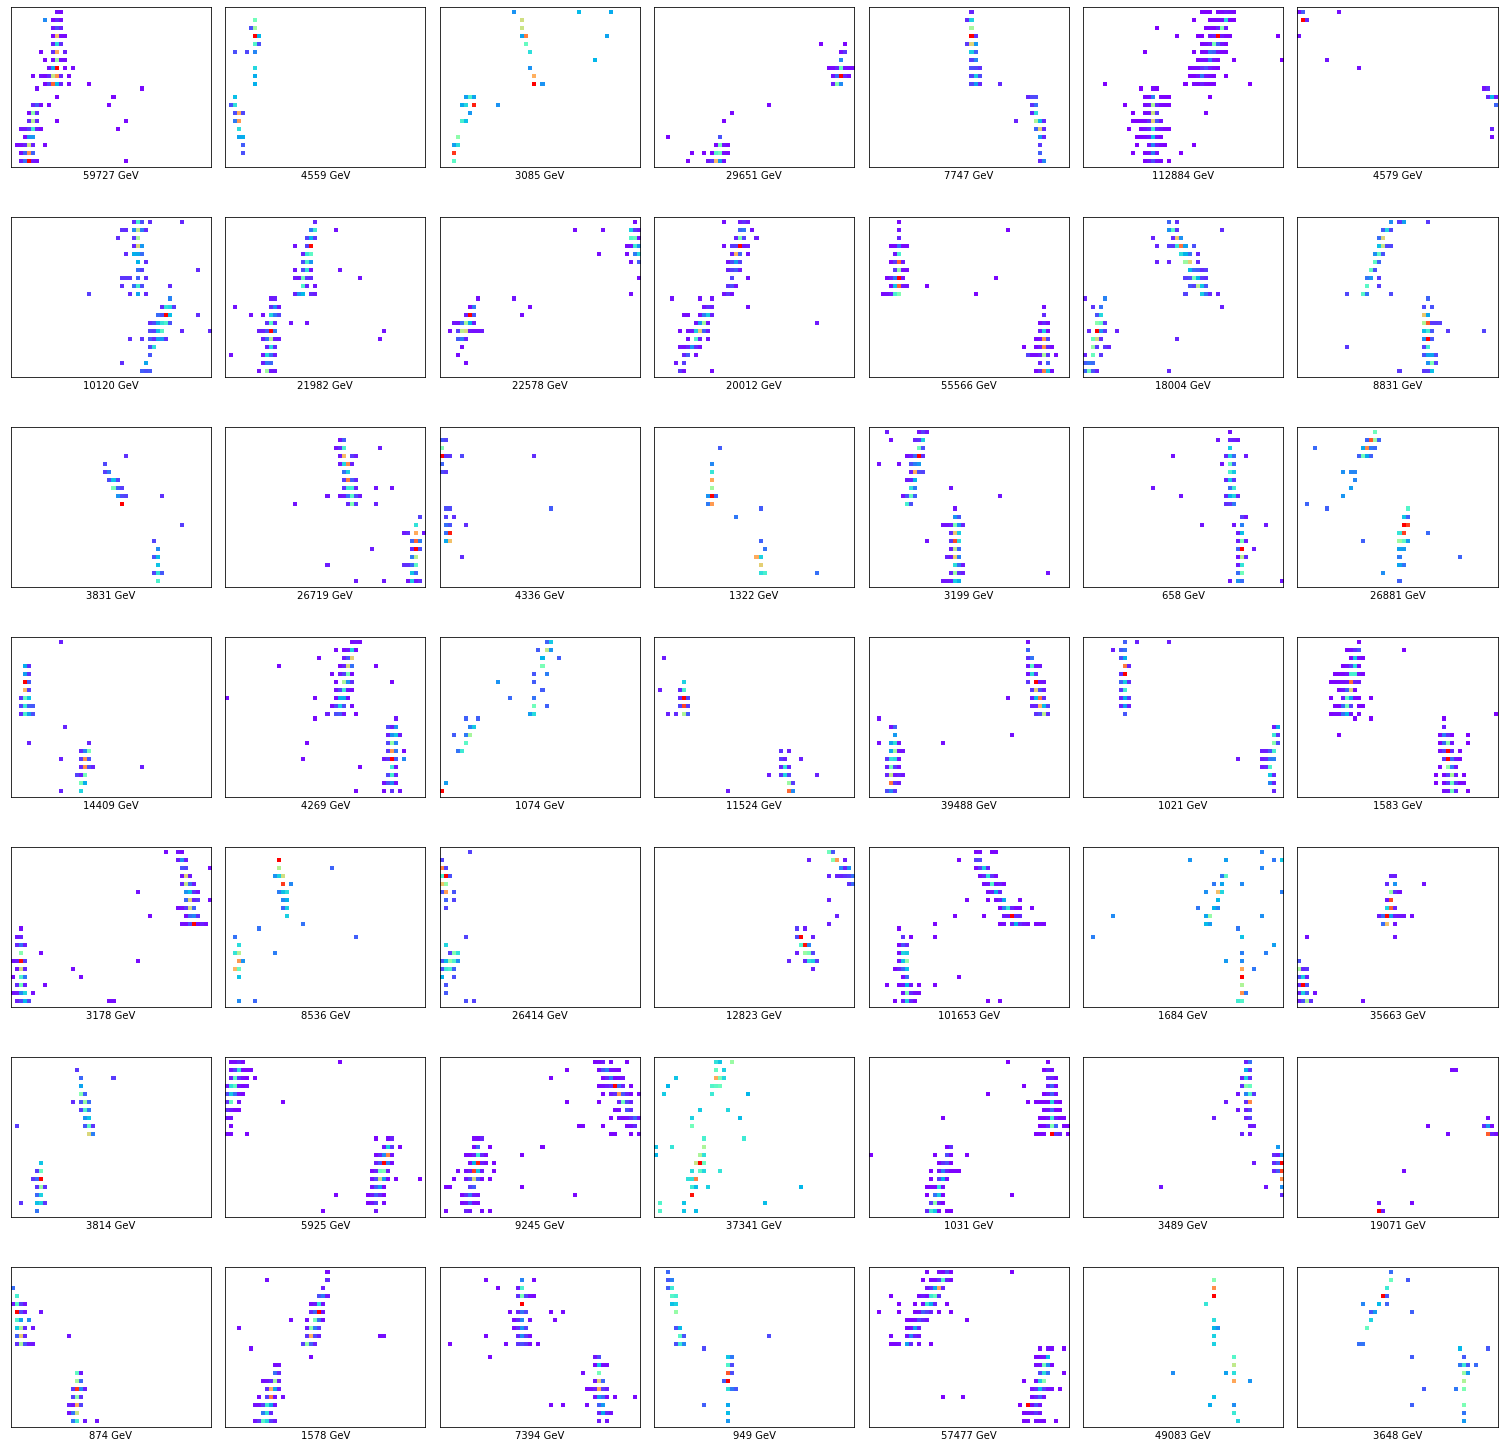

In [33]:
import matplotlib.pyplot as plt

def plot_image(true_energy, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    cmap=plt.cm.rainbow
    cmap.set_under(color='white') 
    plt.imshow(img, cmap=cmap, vmin=1e-7)
    
    plt.xlabel("%d GeV" %(true_energy))

num_rows = 7
num_cols = 7
num_images = num_rows*num_cols
plt.figure(figsize=(3*num_cols, 3*num_rows))

for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    plot_image(TotalEdep[valid_idx][i], xzyz_imgs_vertical[i])
    
    plt.subplots_adjust(wspace = 0.5 )
plt.tight_layout()
plt.show()